In [1]:
'''
sentiment file names for eng/ger
Merge labels and features depending on how labels are aggregated if there are multiple scores for a work.
drop_column reset index???
chunk based features?
complexity features
take out doc2vec_chunk_embedding from default drop columns
'''

'\nsentiment file names for eng/ger\nMerge labels and features depending on how labels are aggregated if there are multiple scores for a work.\ndrop_column reset index???\nchunk based features?\ncomplexity features\ntake out doc2vec_chunk_embedding from default drop columns\n'

In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "../src/")
import numpy as np
import pandas as pd

extracted_features_dir = "../data/extracted_features/"
results_dir = "../data/results/"
sentiment_dir = "../data/evaluationscore/"
canonization_labels_dir = "../data/labels/"
lang = "eng"

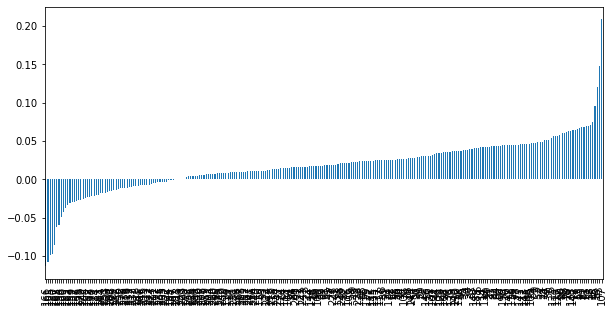

In [3]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.linear_model import Lasso
from sklearn.svm import SVR, SVC
import xgboost
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, f1_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBRegressor
from copy import deepcopy
from scipy.stats import pearsonr
from utils import read_sentiment_scores, read_library_scores
from math import sqrt
get_ipython().run_line_magic("matplotlib", "inline") # %matplotlib inline
import matplotlib.pyplot as plt
from collections import Counter
import statistics
import datetime
import random
random.seed(9)

labels = read_sentiment_scores(sentiment_dir, canonization_labels_dir, lang)
library_scores = read_library_scores(sentiment_dir, canonization_labels_dir, lang)


In [4]:
labels

,book_name,y,c
1,Austen_Jane_Pride-and-Prejudice_1813,0.029731,3
2,Austen_Jane_Sense-and-Sensibility_1811,0.049103,3
3,Barrie_J-M_Auld-Licht-Idylls_1888,0.016107,3
4,Barrie_J-M_Sentimental-Tommy_1896,0.038327,3
5,Beerbohm_Max_Zuleika-Dobson_1911,0.053656,3
...,...,...,...
148,Wollstonecraft_Mary_Mary_1788,0.040233,3
170,Scott_Walter_The-Black-Dwarf_1816,-0.021840,2
177,Beckford_William_Vathek_1786,0.006286,2
234,Radcliffe_Ann_Udolpho_1794,0.004301,2


<AxesSubplot:>

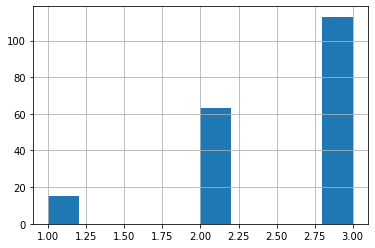

In [5]:
labels["c"].hist()

In [6]:
3 in labels["c"].values

True

In [7]:
## Labels statistics
print(len(pd.unique(labels["book_name"]))) #197

# 254 labels, 197 different book_names -> 57 second/third... reviews
# 36 book_names with more than 1 label, these 36 book_names have 93 labels
# 93 = 36 first reviews + 57 second/third... reviews
# 6 texts with opposing reviews

191


<AxesSubplot:ylabel='Frequency'>

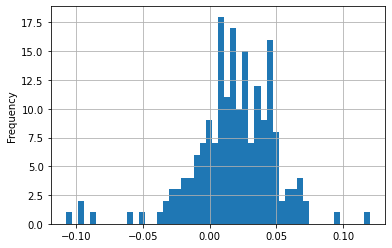

In [8]:
labels["y"].plot.hist(grid=True, bins=50)

In [9]:
class Regression(object):
    def __init__(self, language, features, drop_columns_including, dimensionality_reduction, model_param, model, verbose):
        assert isinstance(drop_columns_including, list)
        for i in drop_columns_including:
            assert isinstance(i, str)
        assert (dimensionality_reduction in ["k_best_f_reg_0_10", "k_best_mutual_info_0_10", "ss_pca_0_95"]) or (dimensionality_reduction is None)
        self._check_class_specific_assertions()
        
        self.language = language
        self.features = features
        self.labels = labels
        self.labels = self._prepare_labels()
        self.drop_columns_including = drop_columns_including
        self.dimensionality_reduction = dimensionality_reduction
        self.model_param = model_param
        self.model = model
        self.verbose = verbose
        self.datetime = datetime.datetime.now().strftime("%Y%m%d%H%M%S")

        if self.features == "book":
            self.df = deepcopy(book_df)
        elif self.features == "chunk":
            self.df = deepcopy(chunk_df)
        elif self.features == "chunk_and_copied_book":
            self.df = deepcopy(chunk_and_copied_book_df)
        elif self.features == "book_and_averaged_chunk":
            self.df = deepcopy(book_and_averaged_chunk_df)

        columns_before_drop = set(self.df.columns)
        if self.drop_columns_including:
            self.df = self.df[[column for column in self.df.columns if not self._drop_column(column)]].reset_index(drop=True)
        columns_after_drop = set(self.df.columns)
        if self.verbose:
            print(f"Dropped {len(columns_before_drop - columns_after_drop)} columns.")
            
    def _check_class_specific_assertions(self):
        assert model in ["xgboost", "svr", "lasso"]
        assert features in ["book", "chunk", "book_and_averaged_chunk", "chunk_and_copied_book"]
    
    def _prepare_labels(self):
        return self.labels.drop(columns="c")

    def _drop_column(self, column):
        for string in self.drop_columns_including:
            if string in column:
                return True
        return False
    
    def _custom_pca(self, train_X):
        for i in range(5, train_X.shape[1], int((train_X.shape[1] - 5) / 10)):
            pca = PCA(n_components=i)
            new_train_X = pca.fit_transform(train_X)
            if pca.explained_variance_ratio_.sum() >= 0.95:
                break
        return new_train_X, pca

    def _select_features(self, train_X, train_y, validation_X):
        if self.dimensionality_reduction == "ss_pca_0_95":
            ss = StandardScaler()
            train_X = ss.fit_transform(train_X)
            validation_X = ss.transform(validation_X)
            train_X, pca = self._custom_pca(train_X)
            validation_X = pca.transform(validation_X)
        elif self.dimensionality_reduction == "k_best_f_reg_0_10":
            k_best = SelectKBest(f_regression, k=np.minimum(int(0.10 * train_X.shape[0]), train_X.shape[1]))
            train_X = k_best.fit_transform(train_X, train_y)
            validation_X = k_best.transform(validation_X)
        elif self.dimensionality_reduction == "k_best_mutual_info_0_10":
            k_best = SelectKBest(mutual_info_regression, k=np.minimum(int(0.10 * train_X.shape[0]), train_X.shape[1]))
            train_X = k_best.fit_transform(train_X, train_y)
            validation_X = k_best.transform(validation_X)
        elif self.dimensionality_reduction is None:
            pass
        return train_X, validation_X
    
    def _impute(self, train_X, validation_X):
        imputer = KNNImputer()
        train_X = imputer.fit_transform(train_X)
        validation_X = imputer.transform(validation_X)
        return train_X, validation_X
    
    def _get_model(self, model_param, train_X=None, train_y=None, train_book_names=None, classification=None):
        if self.model == "xgboost":
            def feval(preds, train_data):
                labels = train_data.get_label().astype(int)
                if classification:
                    preds = preds.argmax(axis=1).astype(int)
                if classification == True:
                    return 'f1', f1_score(labels, preds, average='macro')
                else:
                    return 'rmse', np.sqrt(mean_squared_error(labels, preds))
            class_weights = dict(enumerate(compute_class_weight("balanced", classes=[0, 1, 2, 3], y=train_y.astype(int).tolist())))
            dtrain = xgboost.DMatrix(train_X, label=train_y.astype(int), weight=[class_weights[int(i)] for i in train_y])
            results = []
            df = np.hstack((train_book_names, train_X))
            df = pd.DataFrame(df, columns=["book_name"] + [f"col_{i}" for i in range(train_X.shape[1])])
            for max_depth in [2, 4, 6, 8]:
                for learning_rate in [None, 0.01, 0.033, 0.1]:
                    for colsample_bytree in [0.33, 0.60, 0.75]:
                        if classification:
                            params = {"max_depth": max_depth, "learning_rate": learning_rate, "colsample_bytree": colsample_bytree, "n_jobs": -1, "objective": "multi:softmax", "num_class": 4, "eval_metric": "mlogloss"}
                        else:
                            params = {"max_depth": max_depth, "learning_rate": learning_rate, "colsample_bytree": colsample_bytree, "n_jobs": -1}
                        print("current_params:", params)
                        cv_results = xgboost.cv(
                                        params,
                                        dtrain,
                                        num_boost_round=99999,
                                        seed=42,
                                        nfold=5,
                                        folds=self._split_booknames(df, 5, return_indices=True),
                                        feval=feval,
                                        maximize=classification, # if classification, maximize f1 score.
                                        early_stopping_rounds=10,
                                        verbose_eval=False)
                        if classification:
                            nested_cv_score = cv_results.iloc[len(cv_results)-1]["test-f1-mean"]
                        else:
                            nested_cv_score = cv_results.iloc[len(cv_results)-1]["test-rmse-mean"]
                        num_boost_round = len(cv_results)
                        if classification:
                            results.append({"max_depth": max_depth, "learning_rate": learning_rate, "colsample_bytree": colsample_bytree, "num_boost_round": num_boost_round, "nested_cv_score": nested_cv_score, "objective": "multi:softmax", "num_class": 4, "eval_metric": "mlogloss"})
                        else:
                            results.append({"max_depth": max_depth, "learning_rate": learning_rate, "colsample_bytree": colsample_bytree, "num_boost_round": num_boost_round, "nested_cv_score": nested_cv_score})
            best_parameters = sorted(results, key=lambda x: x["nested_cv_score"], reverse=classification)[0]
            return best_parameters
        elif self.model == "svr":
            return SVR(C=model_param)
        elif self.model == "lasso":
            return Lasso(alpha=model_param)
        elif self.model == "svc":
            return SVC(C=model_param)
        
    def _split_booknames(self, df, nr_splits, return_indices=False):
        """
        Distribute book names over splits.
        All works of an author are in the same split.
        """
        book_names = df["book_name"].unique()
        authors = []
        booknames_authors_mapping = {}

        #Get authors
        for book_name in book_names:
            author = "_".join(book_name.split("_")[:2])
            authors.append(author)
            if author in booknames_authors_mapping:
                booknames_authors_mapping[author].append(book_name)
            else:
                booknames_authors_mapping[author] = []
                booknames_authors_mapping[author].append(book_name)
        #Distribute authors over splits so that each split has approximately the same number of books
        works_per_author = Counter(authors)
        goal_sum = round(len(book_names)/nr_splits)
        tolerance = 0.03
        lower_threshold = goal_sum - round(tolerance*goal_sum)
        upper_threshold = goal_sum + round(tolerance*goal_sum)
        author_splits = []
        popped_dict = {}

        for i in range (0, nr_splits-1):
            works_in_split = 0
            split = []
            curr_author_workcount = 0

            # take values from popped dict first
            if bool(popped_dict):  
                popped = []
                for curr_author, curr_author_workcount in popped_dict.items():
                    # leave item in popped dict if value is too big
                    if works_in_split + curr_author_workcount > upper_threshold:
                        continue
                    else:
                        popped.append(curr_author)
                        split.append(curr_author)
                        works_in_split += curr_author_workcount
                        if works_in_split >= lower_threshold:
                            break
                for current_author in popped:
                    del popped_dict[current_author]
            while works_in_split < upper_threshold:
                if bool(works_per_author):
                    curr_author = random.choice(list(works_per_author.keys()))
                    curr_author_workcount = works_per_author.pop(curr_author)
                    # Put values into separate dict if too big
                    if works_in_split + curr_author_workcount > upper_threshold:
                        popped_dict[curr_author] = curr_author_workcount
                    else:
                        split.append(curr_author)
                        works_in_split += curr_author_workcount
                        if works_in_split >= lower_threshold:
                            break
                else:
                    #ignore upper threshold
                    popped = []
                    for curr_author, curr_author_workcount in popped_dict.items():
                        popped.append(curr_author)
                        split.append(curr_author)
                        works_in_split += curr_author_workcount
                        if works_in_split >= lower_threshold:
                            break
                    for current_author in popped:
                        del popped_dict[current_author]

            author_splits.append(split)
        #Create last split directly from remaining dict
        works_in_last_split = sum(works_per_author.values()) + sum(popped_dict.values())
        split = list(works_per_author.keys()) + list(popped_dict.keys())
        author_splits.append(split)

        if not return_indices:
            #Map author splits to book names
            book_splits = []
            for author_split in author_splits:
                book_split = []
                for author in author_split:
                    book_split.extend(booknames_authors_mapping[author])
                book_splits.append(book_split)
        else:
            book_name_idx_mapping = dict((book_name, index) for index, book_name in enumerate(book_names))
            book_splits = []
            for author_split in author_splits:
                test_split = []
                for author in author_split:
                    test_split.extend([book_name_idx_mapping[book_name] for book_name in booknames_authors_mapping[author]])
                train_split = list(set(book_name_idx_mapping.values()) - set(test_split))
                book_splits.append((train_split, test_split))
        return book_splits
    
    def _combine_df_labels(self, df):
        #Average of sentiscores per book
        agg_labels = self.labels.groupby(by="book_name", as_index=False).mean()
        df = df.merge(right=agg_labels, on="book_name", how="inner", validate="many_to_one")
        return df
    
    def run(self):
        all_predictions = []
        all_labels = []

        train_mses = []
        train_maes = []
        train_r2s = []
        train_corrs = []
        
        validation_mses = []
        validation_maes = []
        validation_r2s = []
        validation_corrs = []
        validation_corr_pvalues = []

        df = self.df
        df = self._combine_df_labels(df)
        book_names_split = self._split_booknames(df, 5)
        all_validation_books = []

        for index, split in enumerate(book_names_split):
            train_df = df[~df["book_name"].isin(split)]
            validation_df = df[df["book_name"].isin(split)]
            
            train_X = train_df.drop(columns=["y", "book_name"]).values
            train_y = train_df["y"].values.ravel()
            validation_X = validation_df.drop(columns=["y", "book_name"]).values
            validation_y = validation_df["y"].values.ravel()
            train_X, validation_X = self._impute(train_X, validation_X)
            #if self.verbose:
            #    print(f"train_X.shape before {self.dimensionality_reduction}: {train_X.shape}, validation_X.shape before {self.dimensionality_reduction}: {validation_X.shape}")
            train_X, validation_X = self._select_features(train_X, train_y, validation_X)
            #if self.verbose:
            #    print(f"train_X.shape after {self.dimensionality_reduction}: {train_X.shape}, validation_X.shape after {self.dimensionality_reduction}: {validation_X.shape}")
            if self.model == "xgboost":
                train_book_names = train_df["book_name"].values.reshape(-1, 1)
                best_parameters = self._get_model(self.model_param, train_X, train_y, train_book_names, classification=False)
                class_weights = dict(enumerate(compute_class_weight("balanced", classes=[0, 1, 2, 3], y=train_y.astype(int).tolist())))
                dtrain = xgboost.DMatrix(train_X, label=train_y.astype(int), weight=[class_weights[int(i)] for i in train_y])
                num_boost_round = best_parameters["num_boost_round"]
                best_parameters.pop("nested_cv_score")
                best_parameters.pop("num_boost_round")
                model = xgboost.train(best_parameters,
                                      dtrain,
                                      num_boost_round=num_boost_round,
                                      verbose_eval=False)
            else:
                model = self._get_model(self.model_param)
                model.fit(train_X, train_y)
            
            train_books = deepcopy(train_df[["book_name", "y"]])
            validation_books = deepcopy(validation_df[["book_name", "y"]])
            
            if self.model == "xgboost":
                train_books["yhat"] = model.predict(xgboost.DMatrix(train_X))
                validation_books["yhat"] = model.predict(xgboost.DMatrix(validation_X))
            else:
                train_books["yhat"] = model.predict(train_X)
                validation_books["yhat"] = model.predict(validation_X)
            
            train_books = train_books.groupby("book_name").mean()
            validation_books = validation_books.groupby("book_name").mean()
            all_validation_books.append(validation_books.reset_index())
            
            train_y = train_books["y"].tolist()
            train_yhat = train_books["yhat"].tolist()
            validation_y = validation_books["y"].tolist()
            validation_yhat = validation_books["yhat"].tolist()
            
            all_labels.extend(validation_y)
            all_predictions.extend(validation_yhat)
            
            train_mse = mean_squared_error(train_y, train_yhat)
            train_mae = mean_absolute_error(train_y, train_yhat)
            train_r2 = r2_score(train_y, train_yhat)
            train_corr = pearsonr(train_y, train_yhat)[0]
            
            validation_mse = mean_squared_error(validation_y, validation_yhat)
            validation_mae = mean_absolute_error(validation_y, validation_yhat)
            validation_r2 = r2_score(validation_y, validation_yhat)
            validation_corr = pearsonr(validation_y, validation_yhat)[0]
            p_value = pearsonr(validation_y, validation_yhat)[1]
            
            train_mses.append(train_mse)
            train_maes.append(train_mae)
            train_r2s.append(train_r2)
            train_corrs.append(train_corr)
            
            validation_mses.append(validation_mse)
            validation_maes.append(validation_mae)
            validation_r2s.append(validation_r2)
            validation_corrs.append(validation_corr)
            validation_corr_pvalues.append(p_value)
            
            if self.verbose:
                print(f"Fold: {index+1}, TrainMSE: {np.round(train_mse, 3)}, TrainMAE: {np.round(train_mae, 3)}, ValMSE: {np.round(validation_mse, 3)}, ValMAE: {np.round(validation_mae, 3)}, ValR2: {np.round(validation_r2, 3)}, ValCorr: {np.round(validation_corr, 3)}")
        all_labels = np.array(all_labels)
        all_predictions = np.array(all_predictions)
        
        # Save y and y_pred for examples
        pd.concat(all_validation_books).to_csv(results_dir + "/y-yhat-" + self.language + "-" + self.datetime + ".csv", index=False)
        
        mean_train_mse = np.mean(train_mses)
        mean_train_rmse = np.mean([sqrt(x) for x in train_mses])
        mean_train_mae = np.mean(train_maes)
        mean_train_r2 = np.mean(train_r2s)
        mean_train_corr = np.mean(train_corrs)
        
        mean_validation_mse = np.mean(validation_mses)
        mean_validation_rmse = np.mean([sqrt(x) for x in validation_mses])
        mean_validation_mae = np.mean(validation_maes)
        mean_validation_r2 = np.mean(validation_r2s)
        mean_validation_corr = np.mean(validation_corrs)
        mean_p_value = self._get_pvalue(validation_corr_pvalues)
        
        if self.verbose:
            print(f"""TrainMSE: {np.round(mean_train_mse, 3)}, TrainRMSE: {np.round(mean_train_rmse, 3)}, TrainMAE: {np.round(mean_train_mae, 3)}, TrainR2: {np.round(mean_train_r2, 3)}, TrainCorr: {np.round(mean_train_corr, 3)}, ValMSE: {np.round(mean_validation_mse, 3)}, ValRMSE: {np.round(mean_validation_rmse, 3)}, ValMAE: {np.round(mean_validation_mae, 3)}, ValR2: {np.round(mean_validation_r2, 3)}, ValCorr: {np.round(mean_validation_corr, 3)}, ValCorrPValue: {np.round(mean_p_value, 3)}""")
            print("\n---------------------------------------------------\n")
            plt.figure(figsize=(4,4))
            plt.xticks(fontsize=15)
            plt.yticks(fontsize=15)
            plt.xlim([0,1])
            plt.ylim([0,1])

            plt.scatter(all_labels, all_predictions, s=6)
            plt.xlabel("Canonization Scores", fontsize=20)
            plt.ylabel("Predicted Scores", fontsize=20)
            plt.savefig(results_dir + lang + "-" + self.model + "-" + str(self.dimensionality_reduction) 
            + "-" + self.features + "-" + "-" + "param" + str(self.model_param) + "-" + self.datetime + ".png", 
            dpi=400, bbox_inches="tight")    
    
            plt.show();
        return mean_train_mse, mean_train_rmse, mean_train_mae, mean_train_r2, mean_train_corr, mean_validation_mse, mean_validation_rmse, mean_validation_mae, mean_validation_r2, mean_validation_corr, mean_p_value, self.datetime


In [10]:
'''
Classification into reviewed/not reviewed
'''

class Classification(Regression):
    def __init__(self, language, features, drop_columns_including, dimensionality_reduction, model_param, model, verbose):
        super().__init__(language, features, drop_columns_including, dimensionality_reduction, model_param, model, verbose)

    def _check_class_specific_assertions(self):
        assert model in ["svc", "xgboost"]
        assert features in ["book", "chunk", "book_and_averaged_chunk", "chunk_and_copied_book"]
        
    def _prepare_labels(self):
        labels = self.labels.drop(columns="y").rename(columns={"c":"y"})
        labels = labels.replace(to_replace={"positive": 3, "not_classified": 2, "negative": 1})
        labels = labels.drop_duplicates(subset="book_name")
        return labels
        
    def _combine_df_labels(self, df):
        #Reviews zum englischen Korpus beginnnen mit 1759 und decken alles bis 1914 ab
        agg_labels = self.labels[["book_name"]].drop_duplicates()
        agg_labels["y"] = 1
        df = df.merge(right=agg_labels, on="book_name", how="left", validate="many_to_one")
        df["y"] = df["y"].fillna(value=0)
        #Select books written after 1759 (year of first review)
        year = df["book_name"].str.replace('-', '_').str.split('_').str[-1].astype('int64')
        df = df.loc[year>=1759]
        return df
    
    def _get_sample_weights(self, df):
        # Weight 
        chunks_per_book = df["book_name"].value_counts(sort=False).rename('chunks_per_book')
        chunks_per_book = chunks_per_book.reset_index().rename(columns={"index":'book_name'})
        chunks_per_book["chunks_per_book"] = 1/chunks_per_book["chunks_per_book"]
        df = df.merge(right=chunks_per_book, how="left", on="book_name")
        sample_weights = df["chunks_per_book"].tolist()
        return sample_weights
    
    def _aggregate_chunk_predictions(self, df):
        g = df.groupby("book_name") 
        
        # Majority vote
        # If one value is more common, assign it to every chunk
        # Therefore, accuracy is either 0 or 1
        # If both values are equally likely, leave them unchanged, and accuracy is 0.5
        def _get_mode_accuracy(group):
            counts = group["yhat"].value_counts()
            if len(counts) == 1:
                mode_acc = counts.index[0]
            else:
                mode_acc = 0.5
            return mode_acc
        mode_accs = g.apply(_get_mode_accuracy).rename("mode_acc").reset_index() 
        mode_acc = mode_accs["mode_acc"].mean()
        
        # Average accuracy within book
        book_acc = g.apply(lambda group: accuracy_score(group["y"], group["yhat"])).mean()
        #Accuracy when each chunk is treated as single document
        chunk_acc = accuracy_score(df["y"], df["yhat"])#, sample_weight = self._get_sample_weights(df))
        return {"mode_acc": mode_acc, "book_acc": book_acc, "chunk_acc": chunk_acc}
        
    def run(self):
        train_accs = []
        validation_accs = []

        df = self.df
        df = self._combine_df_labels(df)
        book_names_split = self._split_booknames(df, 5)
        all_validation_books = []

        for index, split in enumerate(book_names_split):
            train_df = df[~df["book_name"].isin(split)]
            validation_df = df[df["book_name"].isin(split)]
            
            train_X = train_df.drop(columns=["y", "book_name"]).values
            train_y = train_df["y"].values.ravel()
            validation_X = validation_df.drop(columns=["y", "book_name"]).values
            validation_y = validation_df["y"].values.ravel()
            train_X, validation_X = self._impute(train_X, validation_X)
            #if self.verbose:
            #    print(f"train_X.shape before {self.dimensionality_reduction}: {train_X.shape}, validation_X.shape before {self.dimensionality_reduction}: {validation_X.shape}")
            train_X, validation_X = self._select_features(train_X, train_y, validation_X)
            #if self.verbose:
            #    print(f"train_X.shape after {self.dimensionality_reduction}: {train_X.shape}, validation_X.shape after {self.dimensionality_reduction}: {validation_X.shape}")
            if self.model == "xgboost":
                train_book_names = train_df["book_name"].values.reshape(-1, 1)
                best_parameters = self._get_model(self.model_param, train_X, train_y, train_book_names, classification=True)
                class_weights = dict(enumerate(compute_class_weight("balanced", classes=[0, 1, 2, 3], y=train_y.astype(int).tolist())))
                dtrain = xgboost.DMatrix(train_X, label=train_y.astype(int), weight=[class_weights[int(i)] for i in train_y])
                num_boost_round = best_parameters["num_boost_round"]
                best_parameters.pop("nested_cv_score")
                best_parameters.pop("num_boost_round")
                model = xgboost.train(best_parameters,
                                      dtrain,
                                      num_boost_round=num_boost_round,
                                      verbose_eval=False)
            else:
                model = self._get_model(self.model_param)
                model.fit(train_X, train_y)
            
            if self.model == "xgboost":
                train_books["yhat"] = model.predict(xgboost.DMatrix(train_X))
                validation_books["yhat"] = model.predict(xgboost.DMatrix(validation_X))
            else:
                train_books["yhat"] = model.predict(train_X)
                validation_books["yhat"] = model.predict(validation_X)

            train_acc = self._aggregate_chunk_predictions(train_books)
            validation_acc = self._aggregate_chunk_predictions(validation_books)
            
            all_validation_books.append(validation_books)
            
            train_accs.append(train_acc)
            validation_accs.append(validation_acc)
            if self.verbose:
                print(f"Fold: {index+1}, TrainAcc: {np.round(train_acc, 3)}, ValAcc: {np.round(validation_acc, 3)}")
        
        # Save y and y_pred for examples
        all_validation_books = pd.concat(all_validation_books)
        all_validation_books.to_csv(results_dir + "/valiationbooks-class-" + self.language + "-" + self.datetime + ".csv", index=False)
        
        print(confusion_matrix(all_validation_books["y"], all_validation_books["yhat"]))
        print(pd.crosstab(all_validation_books["y"], all_validation_books["yhat"], rownames=['True'], colnames=['Predicted'], margins=True))
                
        train_accs = pd.DataFrame(train_accs)
        validation_accs = pd.DataFrame(validation_accs)
        
        mean_train_mode_acc = train_accs["mode_acc"].mean()
        mean_train_book_acc = train_accs["book_acc"].mean()
        mean_train_chunk_acc = train_accs["chunk_acc"].mean()
        mean_validation_mode_acc = validation_accs["mode_acc"].mean()
        mean_validation_book_acc = validation_accs["book_acc"].mean()
        mean_validation_chunk_acc = validation_accs["chunk_acc"].mean()
        print(mean_train_mode_acc, mean_train_book_acc, mean_train_chunk_acc)
        print(mean_validation_mode_acc, mean_validation_book_acc, mean_validation_chunk_acc)
        
        if self.verbose:
            print(f"""TrainAcc: {np.round(mean_train_acc, 3)}, ValidationAcc: {np.round(mean_validation_acc, 3)}""")
            print("\n---------------------------------------------------\n")
        return None

In [11]:
''' 
Classification into in library/not in library
'''

class LibraryClassification(Classification):
    def _prepare_labels(self):
        return self.labels

In [12]:
'''
Classification into not reviewed/negative/not classified/positive
'''

class MulticlassClassification(Regression):
    def __init__(self, language, features, drop_columns_including, dimensionality_reduction, model_param, model, verbose):
        super().__init__(language, features, drop_columns_including, dimensionality_reduction, model_param, model, verbose)

    def _check_class_specific_assertions(self):
        assert model in ["svc", "xgboost"]
        assert features in ["book", "book_and_averaged_chunk", "chunk_and_copied_book", "chunk"]
        
    def _prepare_labels(self):
        labels = self.labels.drop(columns="y").rename(columns={"c":"y"})
        return labels
        
    def _combine_df_labels(self, df):
        #Reviews zum englischen Korpus beginnnen mit 1759 und decken alles bis 1914 ab
        df = df.merge(right=self.labels, on="book_name", how="left", validate="many_to_one")
        df["y"] = df["y"].fillna(value=0)#(value="not_reviewed")
        #Select books written after 1759 (year of first review)
        year = df["book_name"].str.replace('-', '_').str.split('_').str[-1].astype('int64')
        df = df.loc[year>=1759]
        return df
    
    def _get_sample_weights(self, df):
        # Weight 
        chunks_per_book = df["book_name"].value_counts(sort=False).rename('chunks_per_book')
        chunks_per_book = chunks_per_book.reset_index().rename(columns={"index":'book_name'})
        chunks_per_book["chunks_per_book"] = 1/chunks_per_book["chunks_per_book"]
        df = df.merge(right=chunks_per_book, how="left", on="book_name")
        sample_weights = df["chunks_per_book"].tolist()
        return sample_weights
    
    def _evaluate_predictions(self, df):
        score = f1_score(df["y"], df["yhat"], average='macro')
        return score
        
    def run(self):
        train_f1s = []
        validation_f1s = []

        df = self.df
        df = self._combine_df_labels(df)
        book_names_split = self._split_booknames(df, 10)
        all_validation_books = []

        for index, split in enumerate(book_names_split):
            train_df = df[~df["book_name"].isin(split)]
            validation_df = df[df["book_name"].isin(split)]
            
            train_X = train_df.drop(columns=["y", "book_name"]).values
            train_y = train_df["y"].values.ravel()
            validation_X = validation_df.drop(columns=["y", "book_name"]).values
            validation_y = validation_df["y"].values.ravel()
            train_X, validation_X = self._impute(train_X, validation_X)
            #if self.verbose:
            #    print(f"train_X.shape before {self.dimensionality_reduction}: {train_X.shape}, validation_X.shape before {self.dimensionality_reduction}: {validation_X.shape}")
            train_X, validation_X = self._select_features(train_X, train_y, validation_X)
            #if self.verbose:
            #    print(f"train_X.shape after {self.dimensionality_reduction}: {train_X.shape}, validation_X.shape after {self.dimensionality_reduction}: {validation_X.shape}")
            if self.model == "xgboost":
                train_book_names = train_df["book_name"].values.reshape(-1, 1)
                best_parameters = self._get_model(self.model_param, train_X, train_y, train_book_names, classification=True)
                class_weights = dict(enumerate(compute_class_weight("balanced", classes=[0, 1, 2, 3], y=train_y.astype(int).tolist())))
                dtrain = xgboost.DMatrix(train_X, label=train_y.astype(int), weight=[class_weights[int(i)] for i in train_y])
                num_boost_round = best_parameters["num_boost_round"]
                best_parameters.pop("nested_cv_score")
                best_parameters.pop("num_boost_round")
                model = xgboost.train(best_parameters,
                                      dtrain,
                                      num_boost_round=num_boost_round,
                                      verbose_eval=False)
            else:
                model = self._get_model(self.model_param)
                model.fit(train_X, train_y)
            
            train_books = deepcopy(train_df[["book_name", "y"]])
            validation_books = deepcopy(validation_df[["book_name", "y"]])
            
            if self.model == "xgboost":
                train_books["yhat"] = model.predict(xgboost.DMatrix(train_X))
                validation_books["yhat"] = model.predict(xgboost.DMatrix(validation_X))
            else:
                train_books["yhat"] = model.predict(train_X)
                validation_books["yhat"] = model.predict(validation_X)
            
            train_f1 = self._evaluate_predictions(train_books)
            validation_f1 = self._evaluate_predictions(validation_books)
            all_validation_books.append(validation_books)
            
            train_f1s.append(train_f1)
            validation_f1s.append(validation_f1)
            if self.verbose:
                print(f"Fold: {index+1}, TrainF1: {np.round(train_f1, 3)}, ValF1: {np.round(validation_f1, 3)}")
        
        # Save y and y_pred for examples
        all_validation_books = pd.concat(all_validation_books)
        all_validation_books.to_csv(results_dir + "/valiationbooks-class-" + self.language + "-" + self.datetime + ".csv", index=False)
        
        print(confusion_matrix(all_validation_books["y"], all_validation_books["yhat"]))
        print(pd.crosstab(all_validation_books["y"], all_validation_books["yhat"], rownames=['True'], colnames=['Predicted'], margins=True))

        mean_train_f1 = statistics.mean(train_f1s)
        mean_validation_f1 = statistics.mean(validation_f1s)
        
        if self.verbose:
            print(f"""TrainF1: {np.round(mean_train_f1, 3)}, ValidationF1: {np.round(mean_validation_f1, 3)}""")
            print("\n---------------------------------------------------\n")
        return mean_train_f1, mean_validation_f1

In [13]:
# Drop some columns by default before running cv
def drop_default_columns(df, drop_default_columns_including):
    def _drop_column(column):
        for string in drop_default_columns_including:
            if string in column:
                return True
    df = df[[column for column in df.columns if not _drop_column(column)]].reset_index(drop=True)
    return df

### Cross-validation

# Feature split
complexity_features = []


# Superfluous featues
drop_default_columns_including = ["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding"]

# All parameters
models = ["svr", "lasso", "xgboost", "svc"]
model_params = {"svr": [1], "lasso": [1, 4], "xgboost": [None], "svc": [0.1, 1, 10, 100, 1000, 10000]} #
dimensionality_reduction = ["ss_pca_0_95", 'k_best_f_reg_0_10', 'k_best_mutual_info_0_10', None]
features = ["book", "chunk", "book_and_averaged_chunk", "chunk_and_copied_book"]

# Which parameters to use
full_cv_params = {"model": models, "dimensionality_reduction": dimensionality_reduction, "features": features}
testing_params = {"model": models[3], "dimensionality_reduction": dimensionality_reduction[3], 
                  "features": features[2]}
twoclass_params = {"model": models[3], "dimensionality_reduction": dimensionality_reduction, 
                  "features": features}
multiclass_params = {"model": models[2], "dimensionality_reduction": dimensionality_reduction[-1],
                     "features": ["book", "book_and_averaged_chunk", "chunk", "chunk_and_copied_book"]}
# Old results from chr2021 paper
eng_params = {"model": models[0], "dimensionality_reduction": dimensionality_reduction[0], 
                  "features": features[2], }, # svr, pca, book_and_average_chunk
ger_params = {"model": models[0], "dimensionality_reduction": dimensionality_reduction[0], 
                  "features": features[1]}, # svr, pca, chunk

book_df = pd.read_csv(f"{extracted_features_dir}{lang}/book_df.csv")
book_and_averaged_chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/book_and_averaged_chunk_df.csv")
chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/chunk_df.csv")
chunk_and_copied_book_df = pd.read_csv(f"{extracted_features_dir}/{lang}/chunk_and_copied_book_df.csv")
book_df = drop_default_columns(book_df, drop_default_columns_including)
book_and_averaged_chunk_df = drop_default_columns(book_and_averaged_chunk_df, drop_default_columns_including)
chunk_df = drop_default_columns(chunk_df, drop_default_columns_including)
chunk_and_copied_book_df = drop_default_columns(chunk_and_copied_book_df, drop_default_columns_including)

print(len(book_df.columns), len(book_and_averaged_chunk_df.columns),len(chunk_df.columns),len(chunk_and_copied_book_df.columns),)

len(list(book_and_averaged_chunk_df.columns))

for i in list(book_and_averaged_chunk_df.columns):
    print(i)

In [ ]:
'''
Run two class classification
'''
results = []
param_dict = "multiclass" #"full_cv", "language_specific"
for lang in ["eng"]: #, "ger"]:
    if param_dict == "testing":
        param_dir = testing_params
    elif param_dict == "multiclass":
        param_dir = multiclass_params
    elif param_dict == "full_cv":
        param_dir = full_cv_params
    elif param_dict == "language_specific":
        if lang == "eng":
            param_dir = eng_params
        else: 
            param_dir = ger_params
    
    #Eng: 606 books, 14146 chunks, 13170 chunks of books published after 1759
    book_df = pd.read_csv(f"{extracted_features_dir}{lang}/book_df.csv")
    book_and_averaged_chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/book_and_averaged_chunk_df.csv")
    chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/chunk_df.csv")
    chunk_and_copied_book_df = pd.read_csv(f"{extracted_features_dir}/{lang}/chunk_and_copied_book_df.csv")
    
    book_df = drop_default_columns(book_df, drop_default_columns_including)
    book_and_averaged_chunk_df = drop_default_columns(book_and_averaged_chunk_df, drop_default_columns_including)
    chunk_df = drop_default_columns(chunk_df, drop_default_columns_including)
    chunk_and_copied_book_df = drop_default_columns(chunk_and_copied_book_df, drop_default_columns_including)
    
    for model in [] + [param_dir['model']]:
        model_param = model_params[model]
        for model_param in model_param:
            for dimensionality_reduction in [param_dir["dimensionality_reduction"]]:
                for features in param_dir["features"]:
                    for drop_columns_including in [["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding"],
                                                   ["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding", "->"],
                                                   ["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding", "pos"],
                                                   ["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding", "->", "pos"]]:
                        experiment = MulticlassClassification(
                            language=lang,
                            features=features,
                            drop_columns_including=drop_columns_including,
                            dimensionality_reduction=dimensionality_reduction,
                            model_param=model_param,
                            model=model,
                            verbose=True
                        )
                        mean_train_f1, mean_validation_f1 = experiment.run()
                        print(lang, model, features, drop_columns_including, dimensionality_reduction, 'param=', model_param, mean_train_f1, mean_validation_f1)
                        results.append((lang, model, features, drop_columns_including, dimensionality_reduction, model_param, mean_train_f1, mean_validation_f1))

results_df = pd.DataFrame(results, columns=["lang", "model", "features", "drop_columns_including", 
"dimensionality_reduction", "model_param", "mean_train_f1", "mean_validation_f1"])
results_df.to_csv(results_dir + lang + '_' + param_dict + "_" +"xgboost_nested_cv" + ".csv", index=False)


In [15]:
# '''
# Run Multiclass Classification
# '''
# results = []
# param_dict = "multiclass" #"full_cv", "language_specific"
# for lang in ["ger"]: #, "ger"]:    
#     if param_dict == "testing":
#         param_dir = testing_params
#     elif param_dict == "multiclass":
#         param_dir = multiclass_params
#     elif param_dict == "full_cv":
#         param_dir = full_cv_params
#     elif param_dict == "language_specific":
#         if lang == "eng":
#             param_dir = eng_params
#         else: 
#             param_dir = ger_params
    
#     #Eng: 606 books, 14146 chunks, 13170 chunks of books published after 1759
#     book_df = pd.read_csv(f"{extracted_features_dir}{lang}/book_df.csv")
#     book_and_averaged_chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/book_and_averaged_chunk_df.csv")
#     #chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/chunk_df.csv")
#     #chunk_and_copied_book_df = pd.read_csv(f"{extracted_features_dir}/{lang}/chunk_and_copied_book_df.csv")
    
#     book_df = drop_default_columns(book_df, drop_default_columns_including)
#     book_and_averaged_chunk_df = drop_default_columns(book_and_averaged_chunk_df, drop_default_columns_including)
#     #chunk_df = drop_default_columns(chunk_df, drop_default_columns_including)
#     #chunk_and_copied_book_df = drop_default_columns(chunk_and_copied_book_df, drop_default_columns_including)
    
#     for model in [] + [param_dir['model']]:
#         model_param = model_params[model]
#         for model_param in model_param:
#             for dimensionality_reduction in param_dir["dimensionality_reduction"]:
#                 for features in param_dir["features"]:
#                     for drop_columns_including in [[]]:
#                         #try:
#                         print(lang, model, features, drop_columns_including, dimensionality_reduction, 'param=', model_param)
#                         experiment = MulticlassClassification(
#                             language=lang,
#                             features=features,
#                             drop_columns_including=drop_columns_including,
#                             dimensionality_reduction=dimensionality_reduction,
#                             model_param=model_param,
#                             model=model,
#                             verbose=True
#                         )
#                         mean_train_f1, mean_validation_f1 = experiment.run()
#                         results.append((lang, model, features, drop_columns_including, dimensionality_reduction, model_param, mean_train_f1, mean_validation_f1))

# results_df = pd.DataFrame(results, columns=["lang", "model", "features", "drop_columns_including", 
# "dimensionality_reduction", "model_param", "mean_train_f1", "mean_validation_f1"])
# results_df.to_csv(results_dir + lang + '_' + param_dict + ".csv", index=False)

In [16]:
# 378 texts without reviews, 197 different books with reviews, 6 of which have opposing reviews and are left out.
# 378 + 197 - 6 = 569 texts

In [17]:
# '''
# Run Regression
# '''
# results = []
# param_dict = "testing" #"full_cv", "language_specific"
# for lang in ["eng"]: #, "ger"]:    
#     if param_dict == "testing":
#         param_dir = testing_params
#     elif param_dict == "multiclass":
#         param_dir = multiclass_params
#     elif param_dict == "full_cv":
#         param_dir = full_cv_params
#     elif param_dict == "language_specific":
#         if lang == "eng":
#             param_dir = eng_params
#         else: 
#             param_dir = ger_params
    
#     #Eng: 606 books, 14146 chunks, 13170 chunks of books published after 1759
#     #book_df = pd.read_csv(f"{extracted_features_dir}{lang}/book_df.csv")
#     book_and_averaged_chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/book_and_averaged_chunk_df.csv")
#     #chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/chunk_df.csv")
#     #chunk_and_copied_book_df = pd.read_csv(f"{extracted_features_dir}/{lang}/chunk_and_copied_book_df.csv")
    
#     #book_df = drop_default_columns(book_df, drop_default_columns_including)
#     book_and_averaged_chunk_df = drop_default_columns(book_and_averaged_chunk_df, drop_default_columns_including)
#     #chunk_df = drop_default_columns(chunk_df, drop_default_columns_including)
#     #chunk_and_copied_book_df = drop_default_columns(chunk_and_copied_book_df, drop_default_columns_including)
    
#     for model in [] + [param_dir['model']]:
#         model_param = model_params[model]
#         for model_param in model_param:
#             for dimensionality_reduction in [param_dir["dimensionality_reduction"]]:
#                 for features in [param_dir["features"]]:
#                     for drop_columns_including in [[]]:
#                                                         #try:
#                         experiment = Regression(
#                             language=lang,
#                             features=features,
#                             drop_columns_including=drop_columns_including,
#                             dimensionality_reduction=dimensionality_reduction,
#                             model_param=model_param,
#                             model=model,
#                             verbose=True
#                         )
#                         print(lang, model, features, drop_columns_including, dimensionality_reduction, 'param=', model_param)
#                         mean_train_mse, mean_train_rmse, mean_train_mae, mean_train_r2, mean_train_corr, mean_validation_mse, mean_validation_rmse, mean_validation_mae, mean_validation_r2, mean_validation_corr, mean_p_value, datetime = experiment.run()
#                         results.append((lang, model, features, drop_columns_including, dimensionality_reduction, model_param, mean_train_mse, mean_train_rmse, mean_train_mae, mean_train_r2, mean_train_corr, mean_validation_mse, mean_validation_rmse, mean_validation_mae, mean_validation_r2, mean_validation_corr, mean_p_value))
#                         #except Exception as e:
# #                             print(f"Error in {lang}, {model}, {features}, {drop_columns_including}, {dimensionality_reduction}")
# #                             print(e)
# results_df = pd.DataFrame(results, columns=["lang", "model", "features", "drop_columns_including", 
# "dimensionality_reduction", "model_param", "mean_train_mse", "mean_train_rmse", 
# "mean_train_mae", "mean_train_r2", "mean_train_corr", "mean_validation_mse", "mean_validation_rmse",
# "mean_validation_mae", "mean_validation_r2", "mean_validation_corr", "mean_p_value"])
# results_df.to_csv(results_dir + lang + '_' + regression_' + param_dict + datetime + ".csv", index=False)